In [166]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from scipy import stats
from sklearn.utils import resample

# Load data

In [169]:
# load data from github
path_data = 'https://raw.githubusercontent.com/adamcohen3/caseload_forecasting/refs/heads/main/Processed_Data/'

In [171]:
# Read the Excel file directly from the URL
df_caseload = pd.read_csv(path_data + 'court_historical_data.csv')
df_pred = pd.read_csv(path_data + 'SocioEconomic_data.csv')
df_caseload.head()

,Year,Circuit,Type of Action,Pending at Start,Filed,Total Caseload,Terminated,Pending at End
0,1998,Fifth Circuit,Civil Actions,645,410,1055,350,705
1,1998,Fifth Circuit,Criminal Actions,222,249,471,292,179
2,1998,First Circuit,Civil Actions,8369,5616,13985,5978,8007
3,1998,First Circuit,Criminal Actions,2454,3415,5869,3524,2345
4,1998,Second Circuit,Civil Actions,1520,995,2515,936,1579


In [9]:
# unique cases for caseload
df_caseload['Type of Action'].unique()

array(['Civil Actions', 'Criminal Actions', 'Civil', 'Criminal',
       'Motions', 'Original Proceedings', 'Total Appeals',
       'Adoption Proceedings', 'Marital Actions and Proceedings',
       'Parental Proceedings', 'Traffic Violations'], dtype=object)

In [12]:
df_pred.head(5)

,Year,Total population(thousands),Population growth(%),GDP (million dollars),GDP per Capita (dollars),Honolulu CPI-U (1982-84=100),Civilian unemployment rate (%),Judiciary funding(USD),Median income(USD),Gini coefficient,Poverty rate(%),Crime rate(%),Size of HPD,Government size,Graduation Rate(%),Health Insurance Coverage Rate(%)
0,1997,"1,212",0.7,"37,702","31,116",171.9,5.9,NaN,NaN,NaN,13.9,NaN,NaN,NaN,NaN,NaN
1,1998,"1,215",0.3,"37,503","30,861",171.5,5.8,NaN,NaN,NaN,10.9,NaN,NaN,NaN,NaN,NaN
2,1999,"1,210",-0.4,"38,970","32,199",173.3,5.2,NaN,NaN,NaN,10.8,NaN,NaN,NaN,NaN,NaN
3,2000,"1,214",0.3,"41,089","33,860",176.3,4.2,NaN,NaN,0.4270,8.8,NaN,NaN,NaN,NaN,NaN
4,2001,"1,226",1.0,"42,500","34,667",178.4,4.6,NaN,NaN,0.4323,10.4,NaN,NaN,NaN,NaN,NaN


In [14]:
# check datatype for each feature to make sure everything has right datatype
df_pred.info(), df_caseload.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               34 non-null     int64  
 1   Total population(thousands)        31 non-null     object 
 2   Population growth(%)               31 non-null     float64
 3   GDP (million dollars)              31 non-null     object 
 4   GDP per Capita (dollars)           31 non-null     object 
 5   Honolulu CPI-U (1982-84=100)       31 non-null     float64
 6   Civilian unemployment rate (%)     31 non-null     float64
 7   Judiciary funding(USD)             0 non-null      float64
 8   Median income(USD)                 0 non-null      float64
 9   Gini coefficient                   23 non-null     float64
 10  Poverty rate(%)                    27 non-null     float64
 11  Crime rate(%)                      0 non-null      float64
 

(None, None)

In [16]:
# convert string columns into float
df_pred['Total population(thousands)'] = df_pred['Total population(thousands)'].str.replace(',', '').astype(float)
df_pred['GDP per Capita (dollars)'] = df_pred['GDP per Capita (dollars)'].str.replace(',', '').astype(float)

In [95]:
# select predictors that we have data for the stuy period. PLease note that poverty rate data is missing for the future
poverty = False
if poverty:
    df_pred = df_pred[['Year', 'Total population(thousands)', 'GDP per Capita (dollars)', 'Honolulu CPI-U (1982-84=100)', 'Civilian unemployment rate (%)', 'Poverty rate(%)']]
else: 
    # removing poverty rate as we don't have its projection beyond 2023
    df_pred = df_pred[['Year', 'Total population(thousands)', 'GDP per Capita (dollars)', 'Honolulu CPI-U (1982-84=100)', 'Civilian unemployment rate (%)']]

# Data Exploration
Visualizing how data changes over years across different circuit court. If the ratio of cases stays constant approximately, we can only predict for the total cases and then break it down to circuits based on ratios.

Note: Data for 2024 is not complete. The missing values are shown with "-1" value in the *.csv file to fill out for the future

In [98]:
df_caseload['Year'].unique()

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024], dtype=int64)

In [100]:
## Group by Year and Action, and calculate the total and then ratio for each Action
# Filed cases
df_caseload['Sum_Filed'] = df_caseload.groupby(['Year', 'Type of Action'])['Filed'].transform('sum')
df_caseload['Ratio_Filed'] = df_caseload['Filed'] / df_caseload['Sum_Filed']
# Total cases
df_caseload['Sum_Total'] = df_caseload.groupby(['Year', 'Type of Action'])['Total Caseload'].transform('sum')
df_caseload['Ratio_Total'] = df_caseload['Total Caseload'] / df_caseload['Sum_Total']
# Terminated cases
df_caseload['Sum_Terminated'] = df_caseload.groupby(['Year', 'Type of Action'])['Terminated'].transform('sum')
df_caseload['Ratio_Terminated'] = df_caseload['Terminated'] / df_caseload['Sum_Terminated']

df_caseload

,Year,Circuit,Type of Action,Pending at Start,Filed,Total Caseload,Terminated,Pending at End,Sum_Filed,Ratio_Filed,Sum_Total,Ratio_Total,Sum_Terminated,Ratio_Terminated
0,1998,Fifth Circuit,Civil Actions,645,410,1055,350,705,8021,0.051116,20570,0.051288,8226,0.042548
1,1998,Fifth Circuit,Criminal Actions,222,249,471,292,179,5217,0.047729,8950,0.052626,5133,0.056887
2,1998,First Circuit,Civil Actions,8369,5616,13985,5978,8007,8021,0.700162,20570,0.679874,8226,0.726720
3,1998,First Circuit,Criminal Actions,2454,3415,5869,3524,2345,5217,0.654591,8950,0.655754,5133,0.686538
4,1998,Second Circuit,Civil Actions,1520,995,2515,936,1579,8021,0.124049,20570,0.122265,8226,0.113786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,2023,Fifth Circuit,Traffic Violations,8457,10897,19354,13747,5607,314942,0.034600,490115,0.039489,350529,0.039218
779,2024,First Circuit,Traffic Violations,-1,229846,-1,-1,-1,301592,0.762109,-4,0.250000,-4,0.250000
780,2024,Second Circuit,Traffic Violations,-1,20776,-1,-1,-1,301592,0.068888,-4,0.250000,-4,0.250000
781,2024,Third Circuit,Traffic Violations,-1,39799,-1,-1,-1,301592,0.131963,-4,0.250000,-4,0.250000


In [102]:
# check ratio for each circuit court
action = df_caseload[(df_caseload['Type of Action'] =='Adoption Proceedings') & (df_caseload['Year'] >= 2022)]
pivot = action.pivot_table(index='Year', columns='Circuit', values='Ratio_Filed')
for circuit in pivot.columns:
    print(circuit, np.mean(pivot[circuit]))

Fifth Circuit 0.049233490683017474
First Circuit 0.7271362911980984
Second Circuit 0.0967644141360665
Third Circuit 0.12686580398281755


In [106]:
# print data for specific court, case, and year
df_caseload[(df_caseload['Type of Action'] =='Adoption Proceedings') & (df_caseload['Circuit'] == 'First Circuit') & (df_caseload['Year'] >= 2021)]

,Year,Circuit,Type of Action,Pending at Start,Filed,Total Caseload,Terminated,Pending at End,Sum_Filed,Ratio_Filed,Sum_Total,Ratio_Total,Sum_Terminated,Ratio_Terminated
630,2021,First Circuit,Adoption Proceedings,156,245,401,222,179,411,0.596107,768,0.522135,305,0.727869
642,2022,First Circuit,Adoption Proceedings,43,431,474,330,144,578,0.745675,644,0.736025,410,0.804878
654,2023,First Circuit,Adoption Proceedings,125,419,544,350,194,553,0.757685,721,0.754508,407,0.859951
666,2024,First Circuit,Adoption Proceedings,-1,278,-1,-1,-1,410,0.678049,-4,0.250000,-4,0.250000


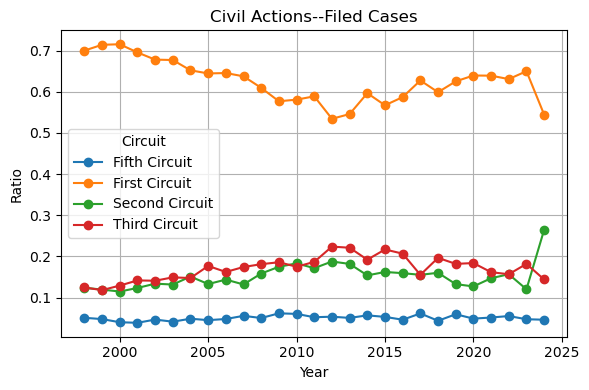

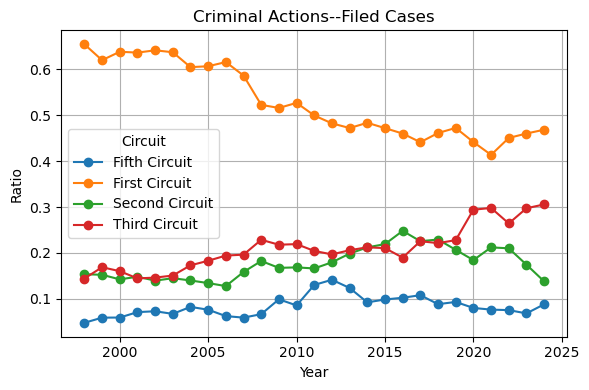

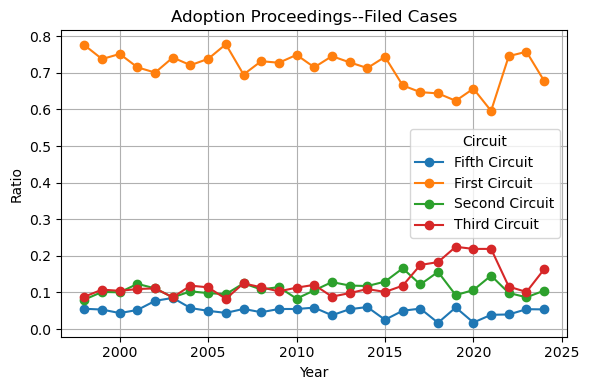

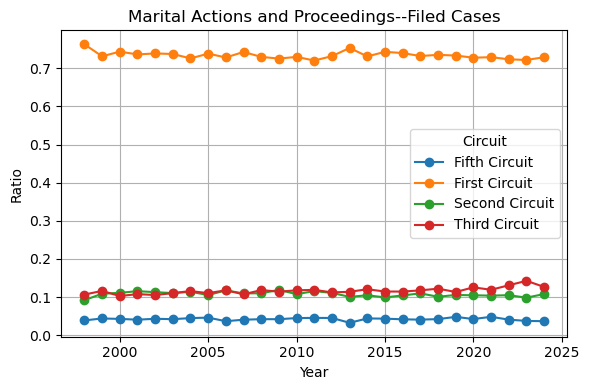

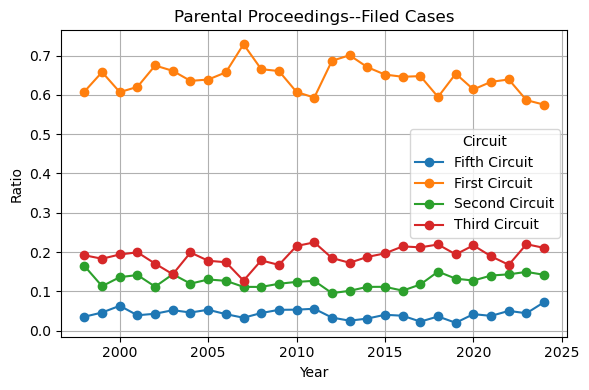

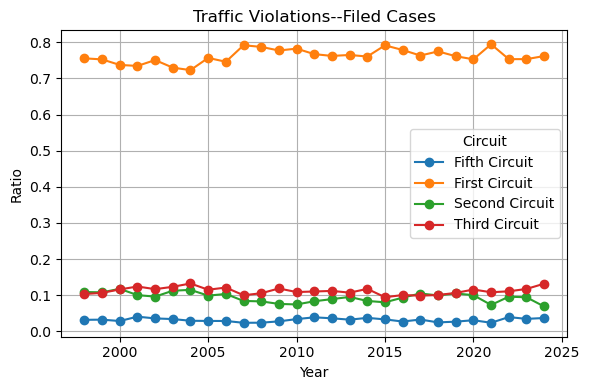

In [178]:
## Plot ratios for each type of filed cases
# Group data by Case. COA cases were removed from the plot since the ratio is always one as the only one available
actions = df_caseload[df_caseload['Circuit'] != 'COA']['Type of Action'].unique()

# Plot each Case separately
for action in actions:
    # Filter the data for the current Action
    action_df = df_caseload[df_caseload['Type of Action'] == action]
    
    # Pivot data for easier plotting
    pivot_df = action_df.pivot_table(index='Year', columns='Circuit', values='Ratio_Filed')

    # Plot
    plt.figure(figsize=(6, 4))
    for circuit in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[circuit], marker='o', label=f'{circuit}')
    
    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.title(f'{action}--Filed Cases')
    plt.legend(title='Circuit')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

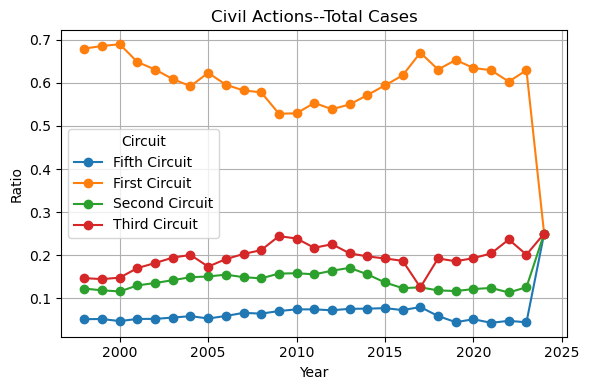

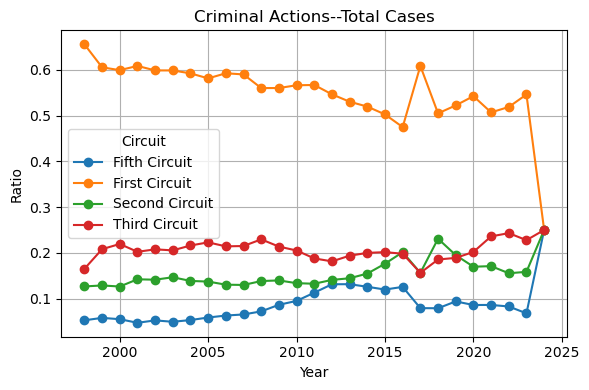

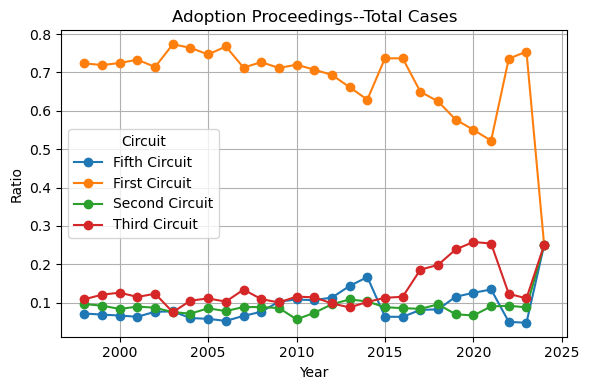

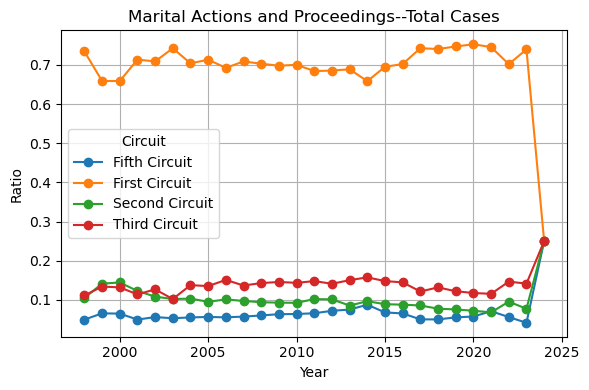

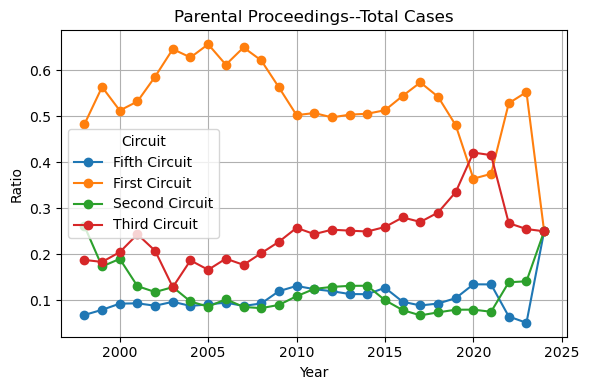

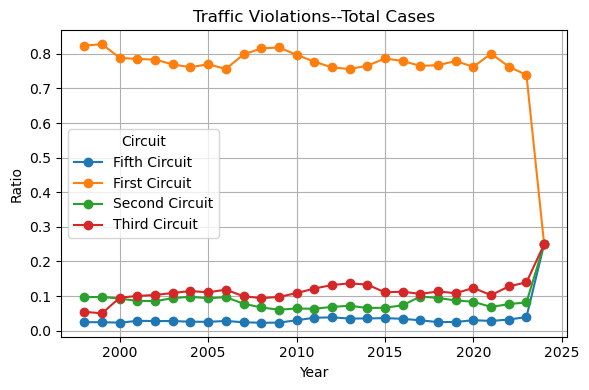

In [179]:
## Plot ratios for each type of Total cases
# Group data by Case. COA cases were removed from the plot since the ratio is always one as the only one available
actions = df_caseload[df_caseload['Circuit'] != 'COA']['Type of Action'].unique()

# Plot each Case separately
for action in actions:
    # Filter the data for the current Action
    action_df = df_caseload[df_caseload['Type of Action'] == action]
    
    # Pivot data for easier plotting
    pivot_df = action_df.pivot_table(index='Year', columns='Circuit', values='Ratio_Total')

    # Plot
    plt.figure(figsize=(6, 4))
    for circuit in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[circuit], marker='o', label=f'{circuit}')
    
    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.title(f'{action}--Total Cases')
    plt.legend(title='Circuit')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

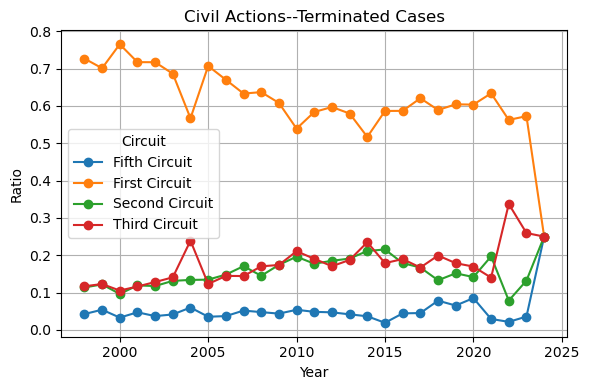

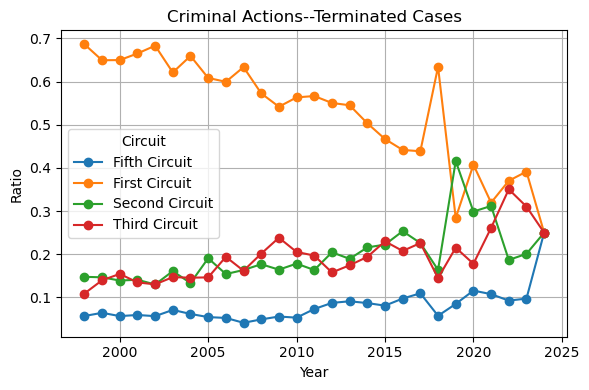

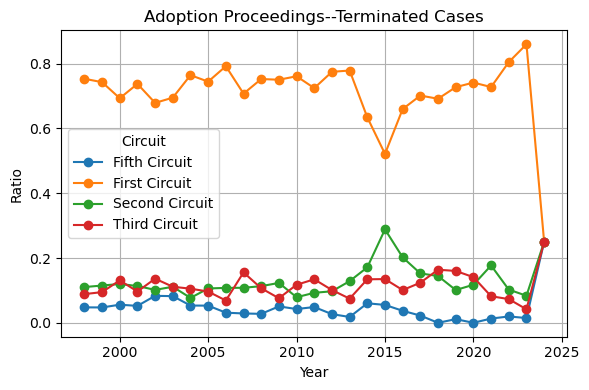

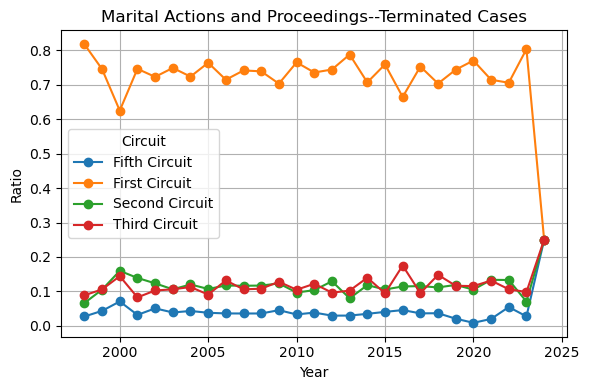

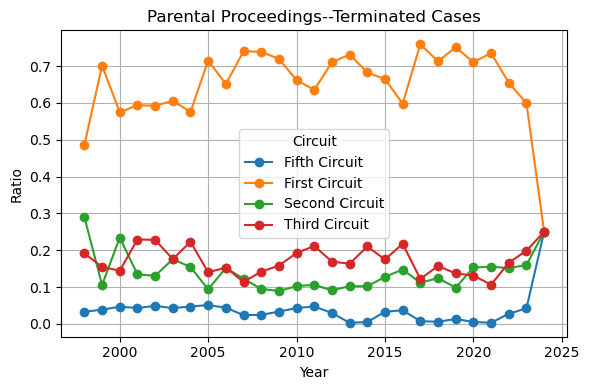

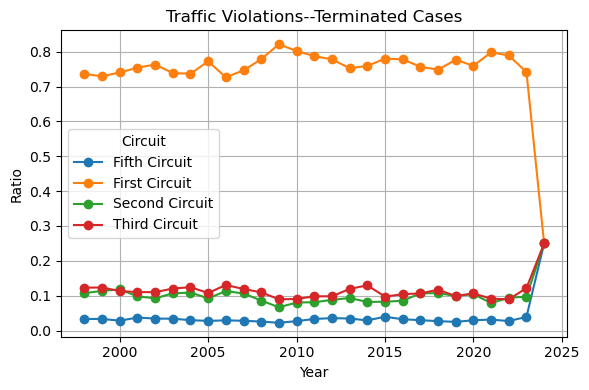

In [180]:
## Plot ratios for each type of Terminated cases
# Group data by Case. COA cases were removed from the plot since the ratio is always one as the only one available
actions = df_caseload[df_caseload['Circuit'] != 'COA']['Type of Action'].unique()

# Plot each Case separately
for action in actions:
    # Filter the data for the current Action
    action_df = df_caseload[df_caseload['Type of Action'] == action]
    
    # Pivot data for easier plotting
    pivot_df = action_df.pivot_table(index='Year', columns='Circuit', values='Ratio_Terminated')

    # Plot
    plt.figure(figsize=(6, 4))
    for circuit in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[circuit], marker='o', label=f'{circuit}')
    
    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.title(f'{action}--Terminated Cases')
    plt.legend(title='Circuit')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Preprocessing

In [108]:
# Case types
print(colored('Circuit court case types:', 'red'), df_caseload[df_caseload['Circuit'] == 'First Circuit']['Type of Action'].unique())
print(colored('Court of Appeals case types:', 'red'), df_caseload[df_caseload['Circuit'] == 'COA']['Type of Action'].unique())

Circuit court case types: ['Civil Actions' 'Criminal Actions' 'Adoption Proceedings'
 'Marital Actions and Proceedings' 'Parental Proceedings'
 'Traffic Violations']
Court of Appeals case types: ['Civil' 'Criminal' 'Motions' 'Original Proceedings' 'Total Appeals']


In [37]:
# filter to a specific case
circuit_court = False # Set to True for circuit court cases. Set to False for COA cases

if circuit_court:
    y = df_caseload[(df_caseload['Circuit'] == 'First Circuit') & (df_caseload['Type of Action'] =='Adoption Proceedings')].reset_index(drop=True) # circuit court cases
    y = y[['Year', 'Sum_Filed']] # Total cases for all circuits
else:
    y = df_caseload[(df_caseload['Circuit'] == 'COA') & (df_caseload['Type of Action'] == 'Motions')].reset_index(drop=True) # courts of appeals cases
    y = y[['Year', 'Filed']] # For specific case


In [122]:
# filter predictors data to cover the range we have data for
X = df_pred[(df_pred['Year'] >= 1998) & (df_pred['Year'] <= 2027)].reset_index(drop=True)

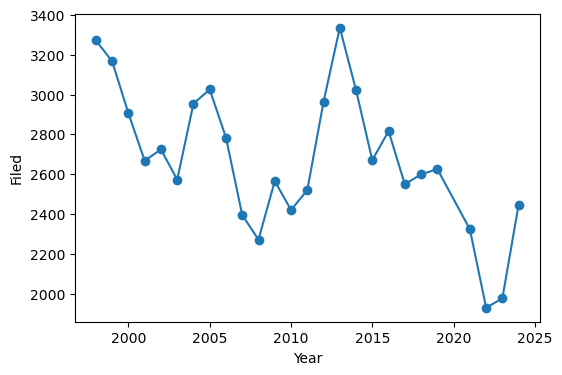

In [124]:
# caseload trend over years
plt.figure(figsize=(6, 4))
plt.plot(y.iloc[:, 0], y.iloc[:,1], marker='o')
plt.xlabel(y.columns[0])
plt.ylabel(y.columns[1])
plt.show()

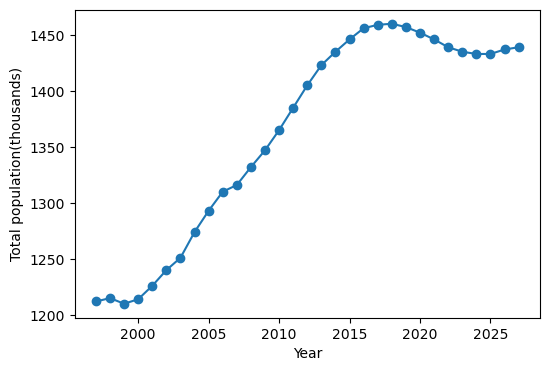

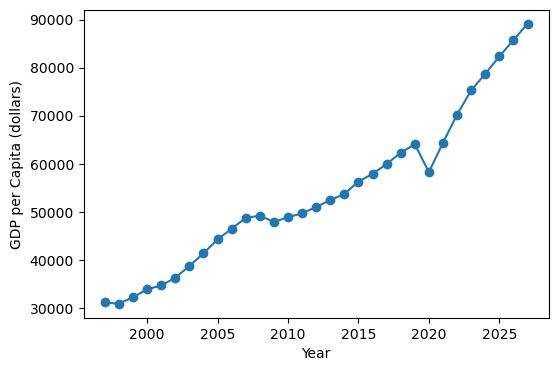

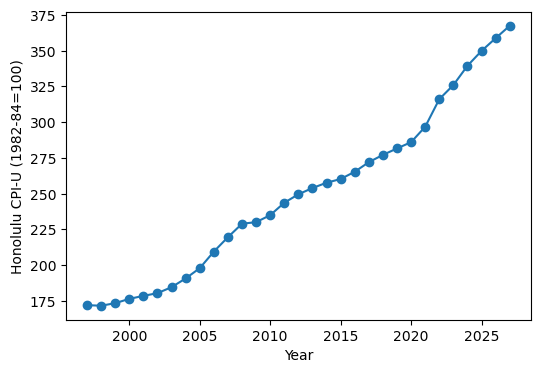

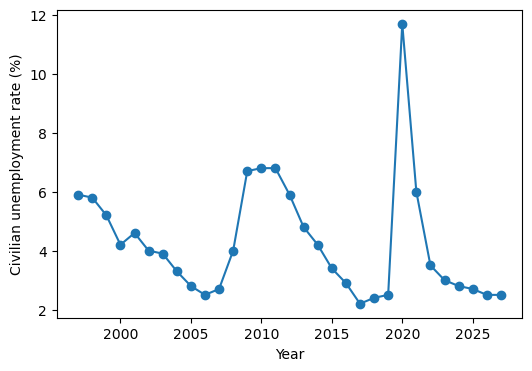

In [126]:
# predictors trend over years
for col in df_pred.drop(columns=['Year']).columns:
    plt.figure(figsize=(6, 4))
    plt.plot(df_pred.iloc[:, 0], df_pred[col], marker='o')
    plt.xlabel(df_pred.columns[0])
    plt.ylabel(col)
    plt.show()

<font size="4">2020 is an outlier in the predictors data and therefore, we dropped it.</font>

In [129]:
# drop year 2020 data from target and predictors
X = X[X['Year'] != 2020].reset_index(drop=True)
y = y[y['Year'] != 2020].reset_index(drop=True)
#X = X[(X['Year'] != 2017) & (X['Year'] != 2020)].reset_index(drop=True)
#y = y[(y['Year'] != 2017) & (y['Year'] != 2020)].reset_index(drop=True)

In [131]:
# split into training and test.
beg_train = 1998 # first year for training data
end_train = 2018 # last year for training data
end_val = 2024 # last year for validation data
end_test = 2027 # last year for test data
# better to split the data randomly instead of keeping last few years for validation. The reason is that the trend in the last few years does not follow the previous years in terms of covariance between predictors
random = True
if random:    
    X_ =  X[(X['Year'] <= end_val) & (X['Year'] >= beg_train)].drop(columns=['Year']).reset_index(drop=True)
    X_train, X_val, y_train, y_val = train_test_split(X_, y, test_size=0.2, random_state=42)
    y_train = y_train.drop(columns=['Year']).reset_index(drop=True)
    y_val = y_val.drop(columns=['Year']).reset_index(drop=True)
    X_test = X[(X['Year'] <= end_test) & (X['Year'] > end_val)].drop(columns=['Year']).reset_index(drop=True)
else:
    X_train = X[(X['Year'] <= end_train) & (X['Year'] >= beg_train)].drop(columns=['Year']).reset_index(drop=True)
    X_val = X[(X['Year'] <= end_val) & (X['Year'] > end_train)].drop(columns=['Year']).reset_index(drop=True)
    X_test = X[(X['Year'] <= end_test) & (X['Year'] > end_val)].drop(columns=['Year']).reset_index(drop=True)
    y_train = y[(y['Year'] <= end_train) & (y['Year'] >= beg_train)].drop(columns=['Year']).reset_index(drop=True)
    y_val = y[(y['Year'] <= end_val) & (y['Year'] > end_train)].drop(columns=['Year']).reset_index(drop=True)

<font size="4">Correlation differs from training to test data which suggests that the training and test datasets come from different distributions. 
Definitely, one big reason why the performance is not good!</font>

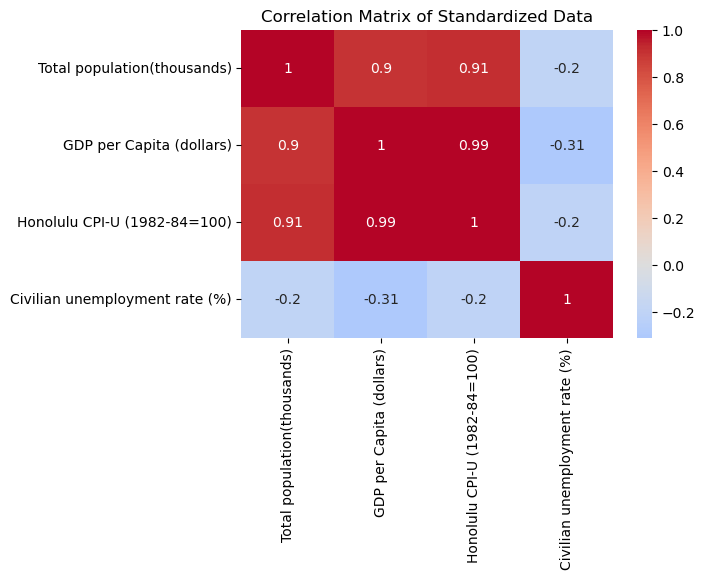

In [134]:
# Calculate correlation between variables in training dataset
correlation_matrix = X_train.corr()
# Visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Standardized Data")
plt.show()

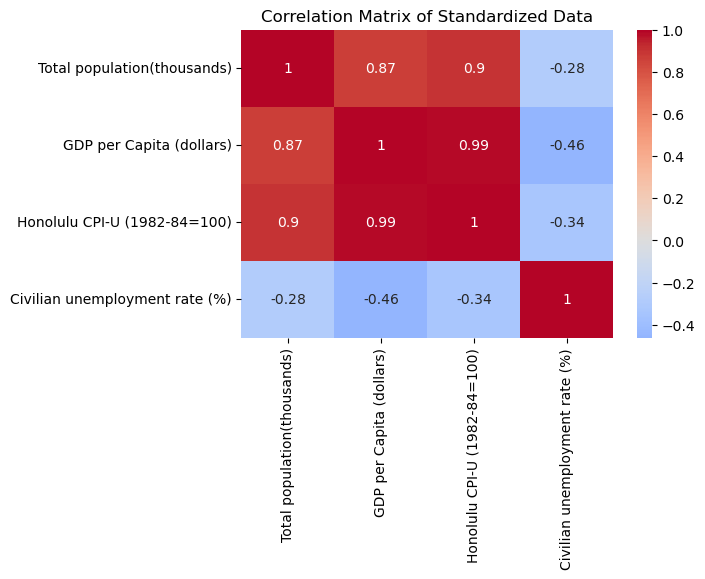

In [136]:
# Calculate correlation between variables in validation set
correlation_matrix = X_val.corr()

# Visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Standardized Data")
plt.show()

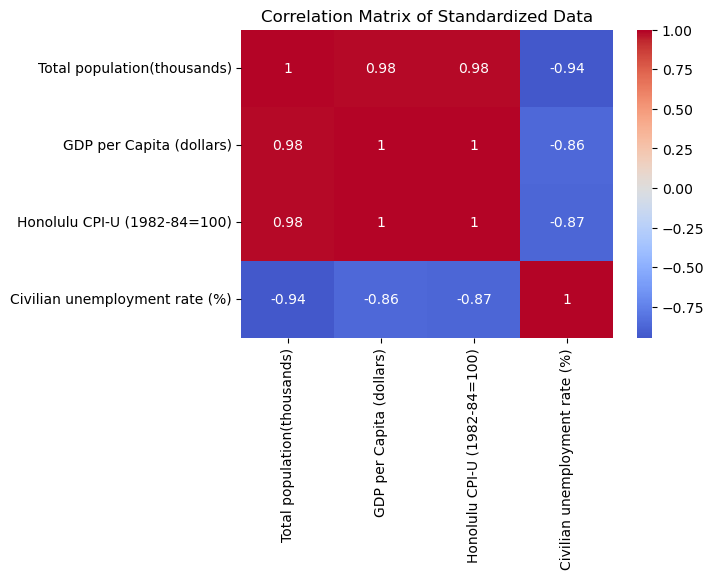

In [138]:
# Calculate correlation between variables in test set
correlation_matrix = X_test.corr()

# Visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Standardized Data")
plt.show()

<font size="4">The relationship between target variable and individual predictors is not linear in most cases.</font>

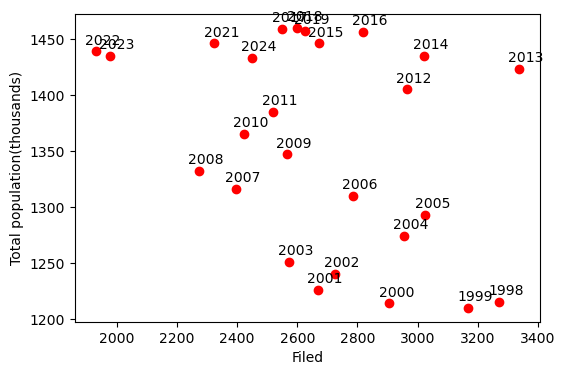

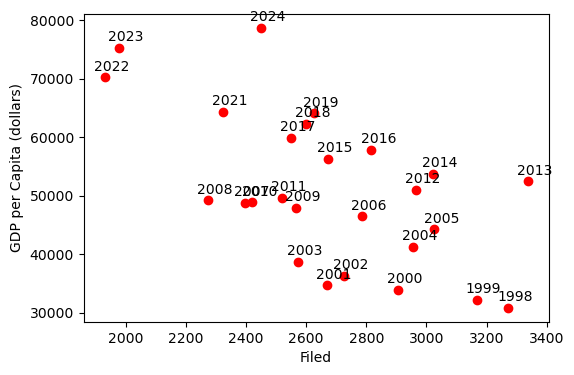

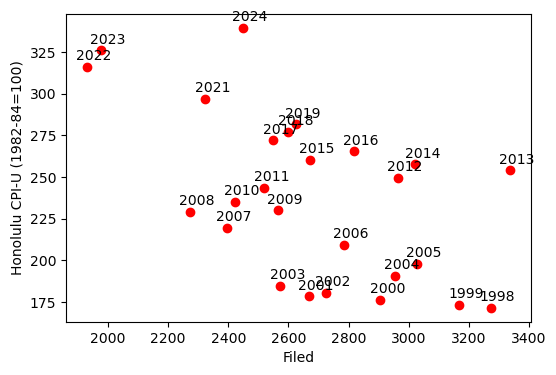

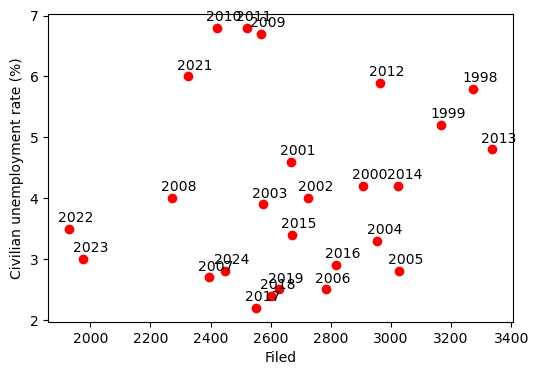

In [141]:
# caseload vs. different predictors
X_temp = X[X['Year'] <= 2024]
for col in X_train.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(y.iloc[:,1], X_temp[col], marker='o', color='red')
    # Add labels to each point
    for i, label in enumerate(y.iloc[:, 0]):
        plt.annotate(label, (y.iloc[i, 1], X_temp[col].iloc[i]), textcoords="offset points", xytext=(5,5), ha='center')
    plt.xlabel(y.columns[1])
    plt.ylabel(col)
    plt.show()

In [146]:
# standardize data to bring them into same scale
scaler = StandardScaler()
# Fit scaler on training data and transform training, validation, and test data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Training and Evaluation

## 1- ModelA: Considering all predictors
This is for the case when we don't want to use regularization. We face overfitting and the model does not generalize well.

In [150]:
modelA = LinearRegression()
modelA.fit(X_train_scaled, y_train)

# Make prediction
y_pred = modelA.predict(X_val_scaled)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
coefficients = modelA.coef_
intercept = modelA.intercept_

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print("Coefficients:", coefficients)
print("Intercept:", intercept)

print("Actual\t Prediction:")
for i, j in zip(y_val.iloc[:,0], y_pred):
    print(i, '\t\t', j[0])

print("Prediction for 2025-2027:")
y_forecast = modelA.predict(X_test_scaled)
years = [2025, 2026, 2027]
for i,j in zip(years, y_forecast):
    print(f'{i}: {j}')

Mean Squared Error: 48429.46474031185
R-squared: 0.7274116783546041
Coefficients: [[ 203.14688621 -735.63639437  356.04284061 -109.50432525]]
Intercept: [2674.95]
Actual	 Prediction:
2784 		 2748.5514912802337
3022 		 2818.7688173711404
3272 		 2911.8440037232954
1977 		 2157.5219802054094
2566 		 2567.6304714768075
2395 		 2687.7696921645174
Prediction for 2025-2027:
2025: [1939.88333727]
2026: [1832.57634208]
2027: [1701.50246861]


## 2- ModelB: Use L1 regularization
Gives better result as we get sparser model that gneralizes better

Best alpha using 1-fold CV: 0.001
Best MSE: 48439.01771707245
Best R2: 0.7273579088174875
Coefficients: [ 203.15859855 -735.35955096  355.76373759 -109.4718515 ] 
Intercept: [2674.95]


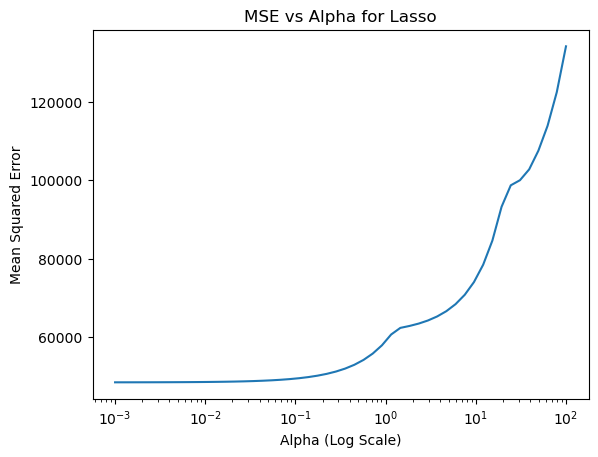

Actual	 Prediction:
2784 	 2748.5766514587694
3022 	 2818.732470527015
3272 	 2911.809346755337
1977 	 2157.5387818464155
2566 	 2567.6713370046755
2395 	 2687.7921657758666


In [154]:
# List of candidate alpha values
alphas = np.logspace(-3, 2, 50)

# List to store Mean Squared Errors for each alpha
mse_values = []
r2_values = []
y_pred_values = []
coeffs_values = []
# Loop over different alpha values to find the best one
for alpha in alphas:
    # Fit Lasso regression model with current alpha
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    
    # Make predictions on the validation set
    y_pred = lasso.predict(X_val_scaled)
    y_pred_values.append(y_pred)
    
    # Calculate the Mean Squared Error and R2 for the current alpha
    mse = mean_squared_error(y_val, y_pred)
    mse_values.append(mse)
    r2 = r2_score(y_val, y_pred)
    r2_values.append(r2)

    # store coefficients and intercept
    coefficients = lasso.coef_
    intercept = lasso.intercept_
    coeffs_values.append([coefficients, intercept])

# Find the alpha that results in the minimum MSE
best_alpha = alphas[np.argmin(mse_values)]
print("Best alpha using 1-fold CV:", best_alpha)
print('Best MSE:', min(mse_values))
print(f"Best R2: {max(r2_values)}")
print(f'Coefficients: {coeffs_values[np.argmin(mse_values)][0]} \nIntercept: {coeffs_values[np.argmin(mse_values)][1]}')

# plot MSE vs. alpha
plt.plot(alphas, mse_values)
plt.xscale('log')
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Lasso')
plt.show()

idx = np.argmin(mse_values)
print("Actual\t Prediction:")
for i, j in zip(y_val.iloc[:,0], y_pred_values[idx]):
    print(i, '\t', j)

## Forecast for 2024-2027

In [157]:
# Fit Lasso regression model with the best alpha
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(X_train_scaled, y_train)    
# Make predictions on the test set
y_forecast = lasso.predict(X_test_scaled)
years = [2025, 2026, 2027]
for i,j in zip(years, y_forecast):
    print(f'{i}: {j}')

2025: 1939.911014140423
2026: 1832.6230143176635
2027: 1701.5745199605576


In [161]:
# coefficients
lasso.coef_, lasso.intercept_

(array([ 203.15859855, -735.35955096,  355.76373759, -109.4718515 ]),
 array([2674.95]))